In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
from astropy import units as u
import ccdproc as ccdp
from ccdproc import subtract_bias

In [2]:
DEBUG = True

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [3]:
files = ccdp.ImageFileCollection('../data/lights_d')
files.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2', 'naxis3', 'gain']

file,imagetyp,exptime,naxis1,naxis2,naxis3,gain
str10,str11,float64,int64,int64,int64,int64
pp_r01.fit,Light Frame,180.0,3840,2160,3,252
pp_r02.fit,Light Frame,180.0,3840,2160,3,252
pp_r03.fit,Light Frame,180.0,3840,2160,3,252
pp_r04.fit,Light Frame,180.0,3840,2160,3,252
pp_r05.fit,Light Frame,180.0,3840,2160,3,252
pp_r06.fit,Light Frame,180.0,3840,2160,3,252
pp_r07.fit,Light Frame,180.0,3840,2160,3,252
pp_r08.fit,Light Frame,180.0,3840,2160,3,252
pp_r09.fit,Light Frame,180.0,3840,2160,3,252


In [4]:
#копируем файлы из папки data в папку reduced
calibrated_data = Path('../reduced_d')
calibrated_data.mkdir(exist_ok=True)

lights = files.files_filtered(imagetyp='Light Frame', include_path=True)

import shutil

for light in lights:
    shutil.copy(light, calibrated_data)

In [5]:
calibrated_path = Path('../reduced_d')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_lights = reduced_images.files_filtered(imagetyp='Light Frame', include_path=True)

light_file = calibrated_lights[0]
light_ccd = CCDData.read(light_file, unit='adu') 

light_data = light_ccd.data[1] #берём зеленый канал

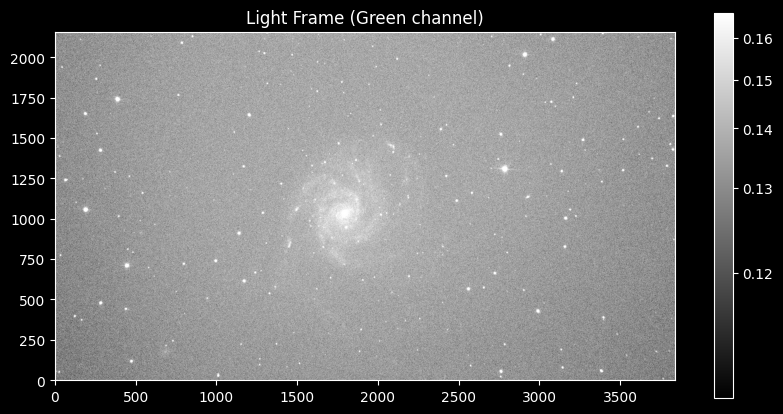

In [6]:
norm = simple_norm(light_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(light_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Light Frame (Green channel)')
plt.show()

Mean: 0.13599978387355804
STD: 0.015707630664110184
MAD STD: 0.007901027798652649


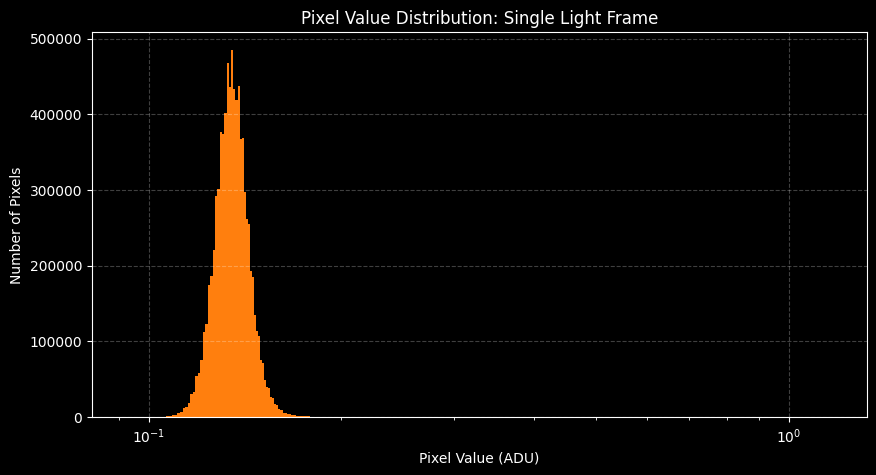

In [15]:
light_hist = light_data.flatten()

print(f'Mean: {np.mean(light_data)}')
print(f'STD: {np.std(light_data)}')
print(f'MAD STD: {mad_std(light_data)}')

plt.figure(figsize=(10, 5))
plt.hist(light_hist, bins=1000, color='tab:orange')
plt.title('Pixel Value Distribution: Single Light Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.semilogx()
plt.show()

In [8]:
combined_dark = CCDData.read(calibrated_data / 'combined_dark_avg_d.fit')

In [10]:
all_reds_d = []
light_ccds = []

for light, file_name in reduced_images.ccds(imagetyp='Light Frame',
                                           ccd_kwargs={'unit': 'adu'},
                                           return_fname=True):
    
    print(f"Mean before anything: {np.mean(light.data)}")

    # Выделяем зеленый канал
    green_data = light.data[1]

    # Создаем новый CCDData с зелёным каналом (один канал)
    green_ccd = CCDData(green_data, unit=light.unit, meta=light.meta)

    # Можно работать с green_ccd дальше
    reduced = ccdp.subtract_dark(green_ccd, combined_dark, 
                                 exposure_time='exptime', exposure_unit=u.second)

    all_reds_d.append(reduced)

Mean before anything: 0.10552497953176498


Mean before anything: 0.10450331121683121


Mean before anything: 0.10134009271860123


Mean before anything: 0.10294020920991898


Mean before anything: 0.1022024005651474


Mean before anything: 0.10233470797538757
Mean before anything: 0.09921231120824814


Mean before anything: 0.09794505685567856


Mean before anything: 0.09905944764614105


Mean before anything: 0.09855206310749054
Mean before anything: 0.09975425899028778


Mean before anything: 0.09969953447580338


Mean before anything: 0.10075672715902328


Mean before anything: 0.10315526276826859


Mean before anything: 0.10296876728534698


Mean before anything: 0.103818379342556


Mean before anything: 0.1026720404624939


Mean before anything: 0.10264573246240616
Mean before anything: 0.10286222398281097


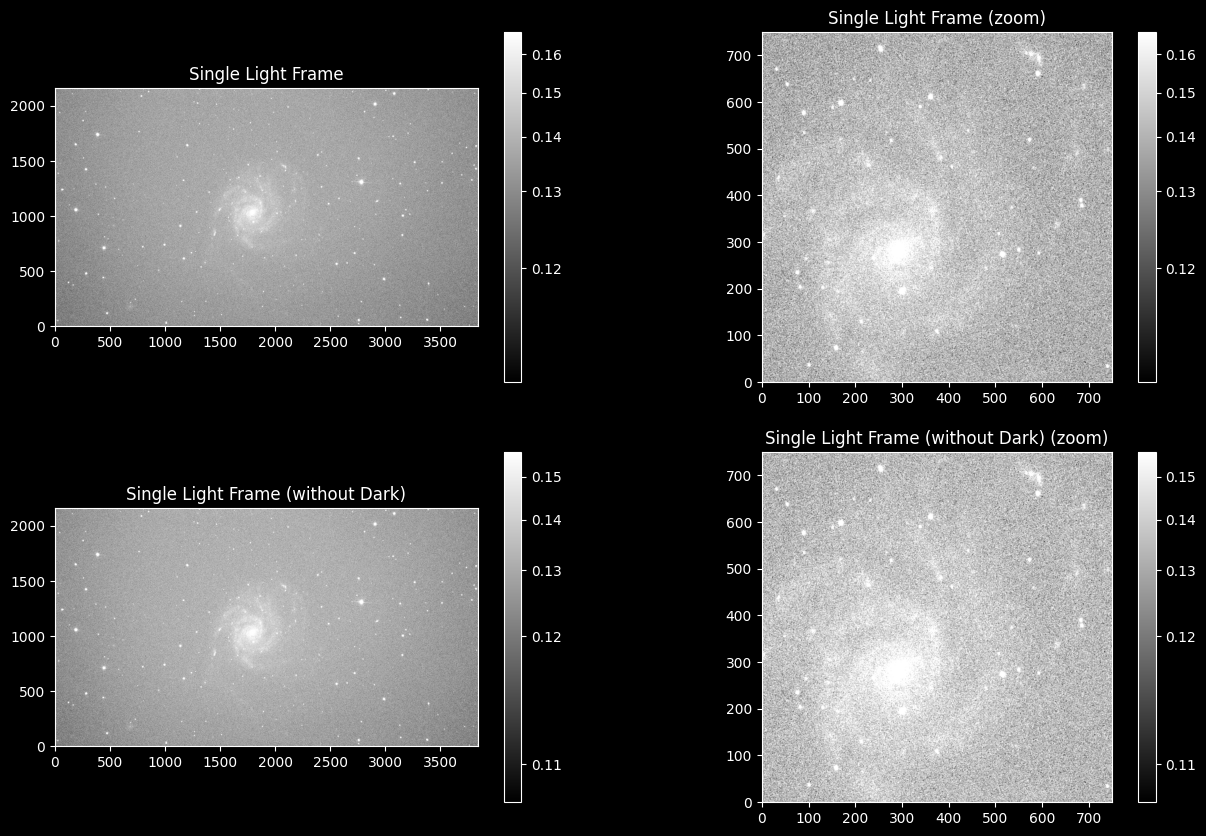

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(light_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Light Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(light_data[750:1500, 1500:2250], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Light Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(all_reds_d[0].data, stretch='sqrt', percent=99)
im3 = ax3.imshow(all_reds_d[0].data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Single Light Frame (without Dark)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(all_reds_d[0].data, stretch='sqrt', percent=99)
im4 = ax4.imshow(all_reds_d[0].data[750:1500, 1500:2250], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Single Light Frame (without Dark) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()

Single Light Frame
Mean: 0.13599978387355804
STD: 0.015707630664110184
MAD STD: 0.007901027798652649 

Single Light Frame (w/o Dark)
Mean: 0.13059177142862888
STD: 0.015267617871981205
MAD STD: 0.0077047677644321196


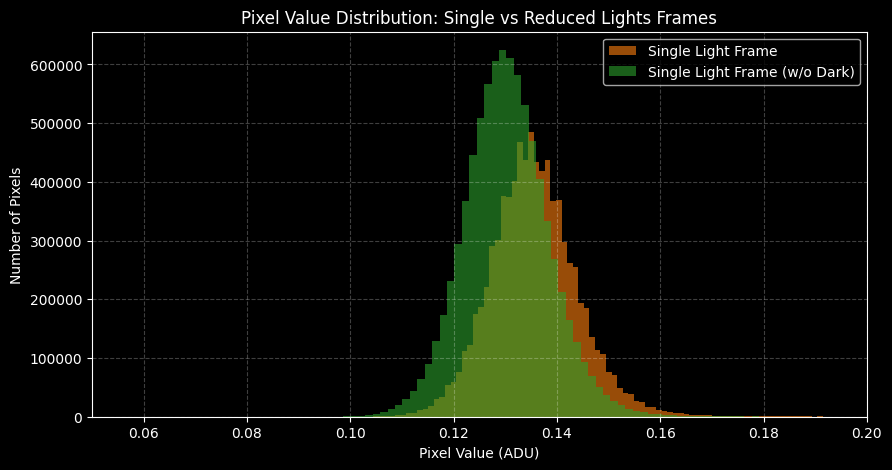

In [20]:
print('Single Light Frame')
print(f'Mean: {np.mean(light_data)}')
print(f'STD: {np.std(light_data)}')
print(f'MAD STD: {mad_std(light_data)} \n')

print('Single Light Frame (w/o Dark)')
print(f'Mean: {np.mean(all_reds_d[0].data)}')
print(f'STD: {np.std(all_reds_d[0].data)}')
print(f'MAD STD: {mad_std(all_reds_d[0].data)}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(light_data.flatten(), bins=1000, color='tab:orange', alpha=0.6, label='Single Light Frame')
plt.hist(all_reds_d[0].data.flatten(), bins=1000, color='tab:green', alpha=0.6, label='Single Light Frame (w/o Dark)')
plt.title('Pixel Value Distribution: Single vs Reduced Lights Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.xlim(0.05,0.2)
plt.legend()
plt.show()